In [1]:
%load_ext autoreload
%autoreload 2

# Genetic algorithm for finding circuit topologies 

Reproduction of the notebook from `genetic_circuit_generator` [23_Monte_Carlo_adaptability_2](https://github.com/olive004/genetic_circuit_generator/blob/main/notebooks/23_Monte_Carlo_adaptability_2.ipynb).

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


jax.config.update('jax_platform_name', 'gpu')


# jupyter nbconvert --to notebook --execute 23_Monte_Carlo_adaptability_2.ipynb --output=23_Monte_Carlo_adaptability_2_large.ipynb --ExecutePreprocessor.timeout=-1
np.random.seed(0)
jax.devices()

[cuda(id=0), cuda(id=1)]

In [3]:
top_write_dir = os.path.join('data', '32_genetic_algos')
os.makedirs(top_write_dir, exist_ok=True)

# First visualise old runs

In [4]:
df = pd.read_csv(os.path.join(top_write_dir, '23_Monte_Carlo_adaptability_2', '23_Monte_Carlo_adaptability_n2000.csv'))
df.rename(columns={'Is parent circuit': 'Parent in next round'}, inplace=True)

df.head()

,Adaptability,Sensitivity,Precision,Parent in next round,Circuit idx,Species,Step,Params energy,Params equilibrium constants,Params rates
0,834.006897,0.366552,1.439166e+07,True,1627,RNA_2,16,"[-0.6703937649726868, -0.8651988506317139, -11...","[2.867693865482579e-06, 3.3513133530505e-06, 0...","[526.4093627929688, 450.444580078125, 0.070071..."
1,833.182739,0.363782,4.063727e+06,True,1718,RNA_2,17,"[-0.6461842060089111, -0.6556981801986694, -11...","[2.8126876259193523e-06, 2.834176029864466e-06...","[536.7041015625, 532.6348876953125, 0.07377805..."
2,832.450073,0.363100,1.902003e+06,True,1551,RNA_2,15,"[-0.2916331887245178, -1.2521716356277466, -11...","[2.1180590010771994e-06, 4.567336873151362e-06...","[712.7190551757812, 330.51666259765625, 0.0749..."
3,832.395752,0.353807,3.015780e+06,True,1369,RNA_2,13,"[-0.7438141703605652, -0.9114807844161987, -11...","[3.0411765692406334e-06, 3.4777231121552177e-0...","[496.380615234375, 434.0716552734375, 0.089496..."
4,832.301758,0.387133,6.357794e+05,True,671,RNA_2,6,"[-0.651785671710968, -12.02252197265625, -11.1...","[2.825320279953303e-06, 0.02521541342139244, 0...","[534.3043823242188, 0.059867389500141144, 0.11..."


/tmp/ipykernel_1061349/3261215673.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


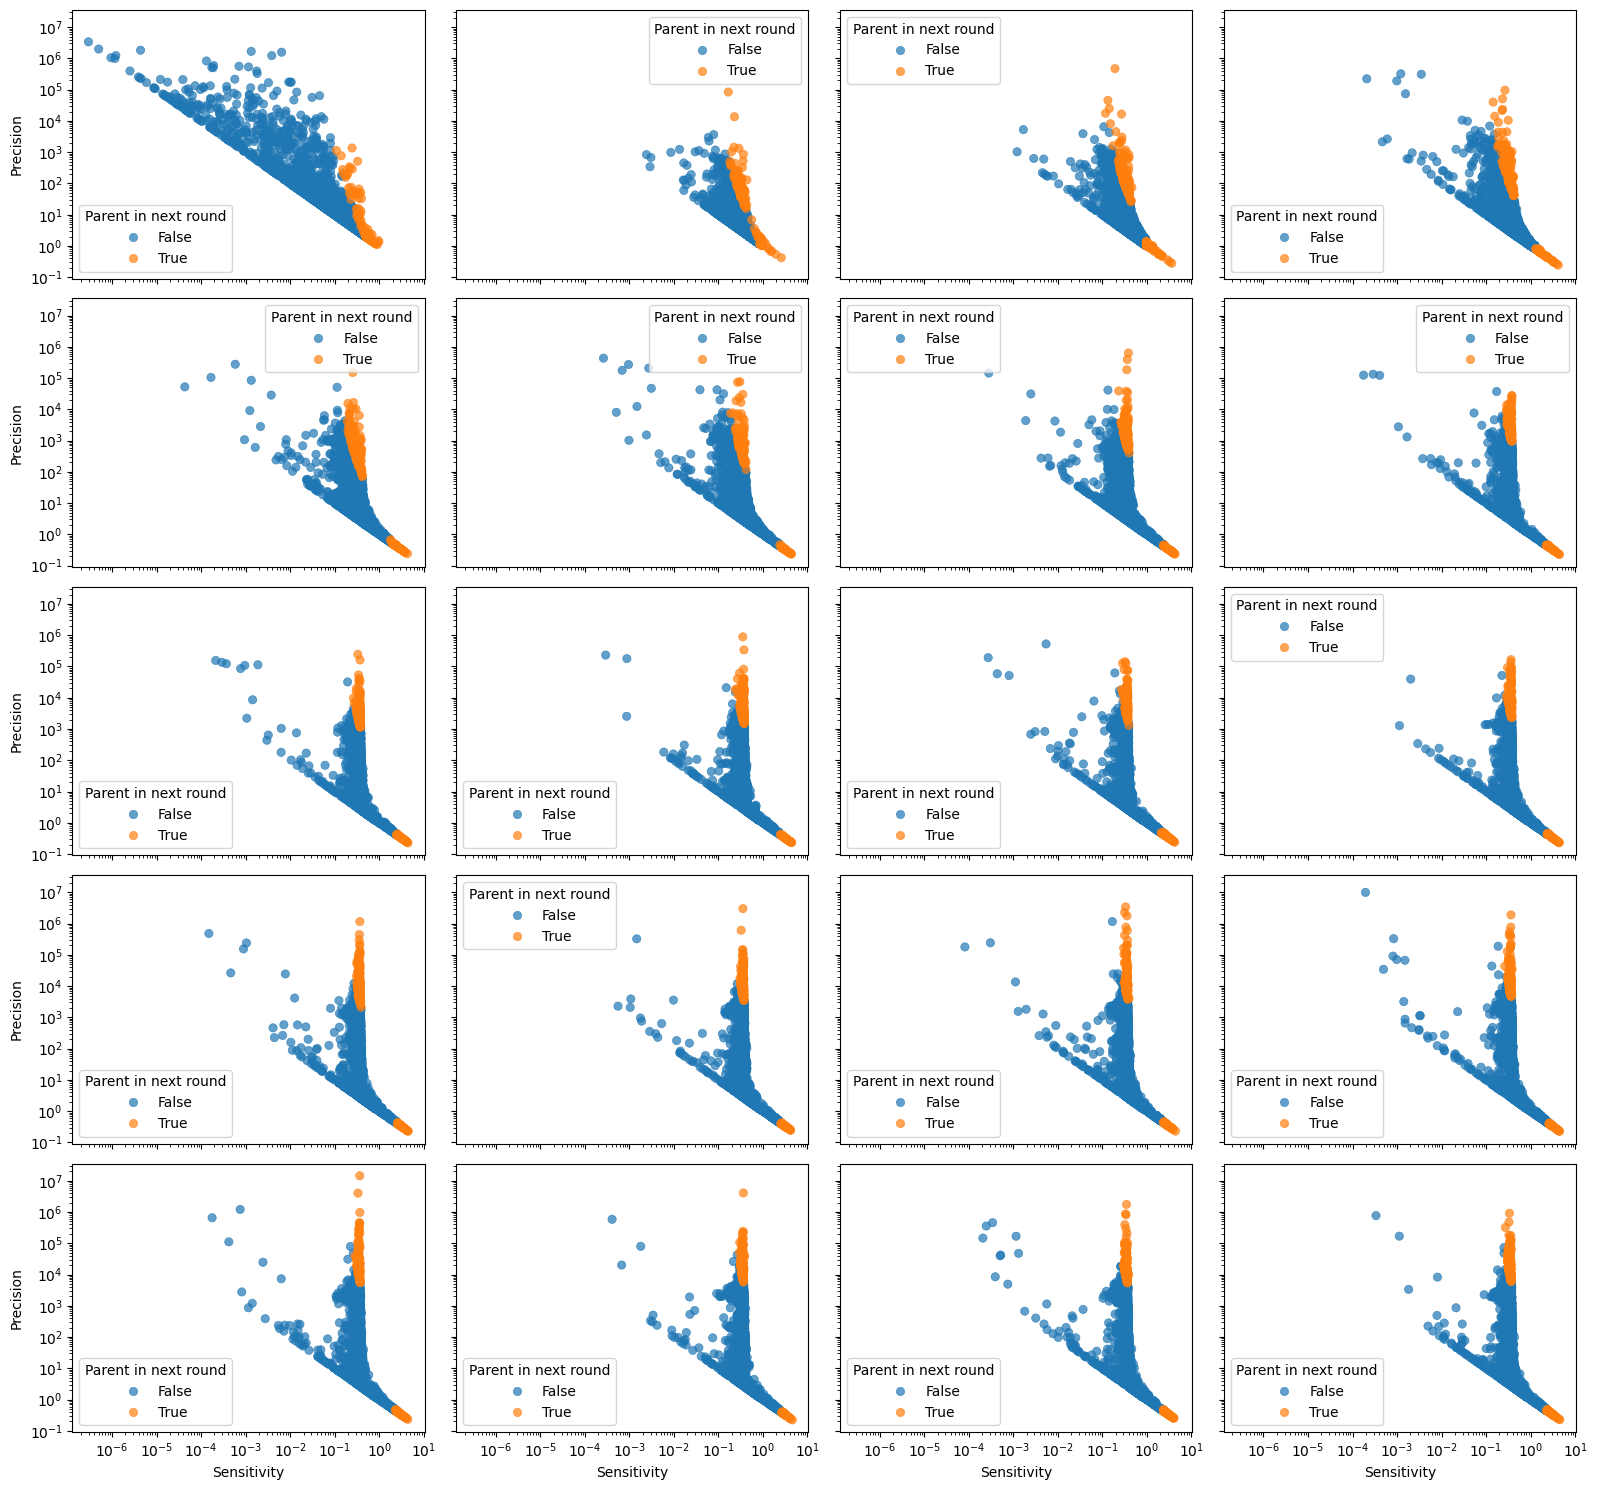

In [5]:
n_step = int(df['Step'].max()) + 1
nrows = int(np.ceil(np.sqrt(n_step)))
ncols = int(np.ceil(n_step / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), 
                        constrained_layout=True, sharex=True, sharey=True)
for step in range(n_step):
    step_df = df[df['Step'] == step].sort_values('Parent in next round')
    sns.scatterplot(data=step_df, x='Sensitivity', y='Precision', hue='Parent in next round', ax=axs.flat[step],
                    alpha=0.7, edgecolor=None)
    axs.flat[step].set_xscale('log')
    axs.flat[step].set_yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_parent.png'), dpi=300)

# Set up test circuits

Not loading anything - just defining variables and random energies.

In [6]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 2000
dt0 = 0.0001
dt1 = 0.5
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Tsit5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 8000
save_steps = 100
save_steps_uselog = True


# MC parameters
total_steps = 20
total_samples = 6000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 100
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

In [7]:
fn_save = os.path.join(top_write_dir, 'genetic_algorithm_results.csv')

# Initialise circuits

In [8]:
# sim_func = jax.jit(jax.vmap(
#     partial(bioreaction_sim_dfx_expanded,
#             t0=t0, t1=t1, dt0=dt0,
#             forward_rates=forward_rates,
#             inputs=inputs,
#             outputs=outputs,
#             solver=get_diffrax_solver(
#                 sim_method),
#             saveat=dfx.SaveAt(
#                 ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
#             stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
#                                                          choice=stepsize_controller)
#             )))

# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

def compute_adaptability():
    pass

# Run the genetic algorithm

In [9]:
run_mc = True


In [10]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, total_samples: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        a = analytic[~np.isnan(analytic[:, idxs_output]).flatten()][:, idxs_output].flatten()
        idxs_next = jnp.where(a >= jnp.sort(a)[-n_chosen:].min())[0]
        return idxs_next
    
    def get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a > 0:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s > 0: 
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        i_while = 0
        while len(idxs_next) < choose_max:
            idxs_rnd = choose_next_rnd(choose_max - len(idxs_next), total_samples)
            idxs_next = jnp.concatenate([idxs_next, idxs_rnd])
            # if len(adaptability) == 0:
            # else:
            #     idxs_next_more_a = get_next_idxs(adaptability, choose_max - len(idxs_next))
            #     idxs_next = jnp.concatenate([idxs_next, idxs_next_more_a])
            i_while += 1
            if i_while > 10:
                print('While loop was going forever...')
                break
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    if len(idxs_next) == 0:
        print('Not sure how this happened...')
        idxs_next = choose_next_rnd(choose_max - len(idxs_next), total_samples)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def choose_next_rnd(n_choose, total_samples):
    return jax.random.randint(jax.random.PRNGKey(0), (n_choose,), 0, total_samples)


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1





Starting iteration 1 out of 20


Simulating batch 0: 0 to 6000 / 6000
Steady states:  500  iterations.  28669  left to steady out.  0:00:23.002922
Steady states:  1000  iterations.  21597  left to steady out.  0:00:46.061660
Steady states:  1500  iterations.  17979  left to steady out.  0:01:09.255157
Done:  0:01:32.144006
Steady states:  500  iterations.  15799  left to steady out.  0:00:21.102532
Steady states:  1000  iterations.  13527  left to steady out.  0:00:43.086886
Steady states:  1500  iterations.  12287  left to steady out.  0:01:04.007332
Done:  0:01:24.785123
Choosing 600 next circuits
Mutated and expanding 600 into 6000 next circuits


Starting iteration 2 out of 20


Simulating batch 0: 0 to 6000 / 6000
Steady states:  500  iterations.  30147  left to steady out.  0:00:20.617672
Steady states:  1000  iterations.  23171  left to steady out.  0:00:41.537102
Steady states:  1500  iterations.  19318  left to steady out.  0:01:01.682879
Done:  0:01:22.332246
Steady states:

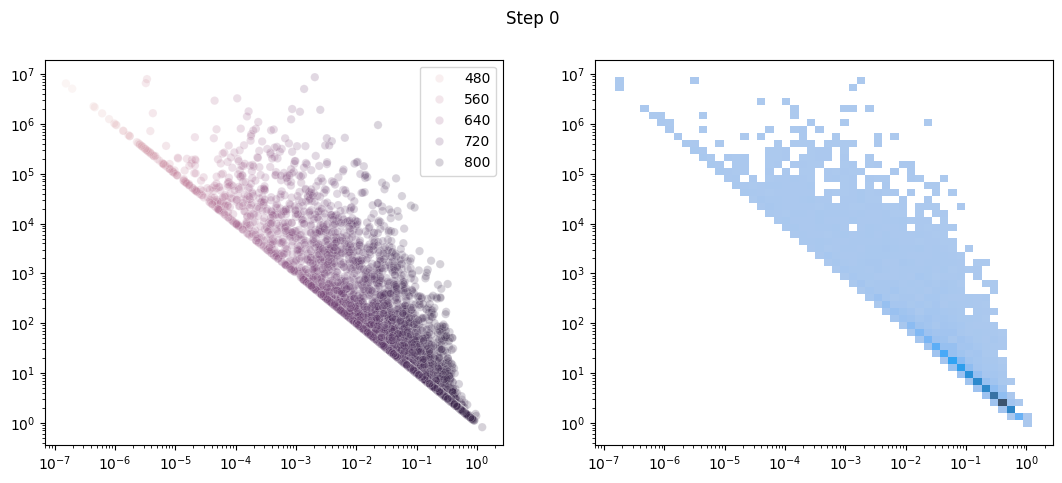

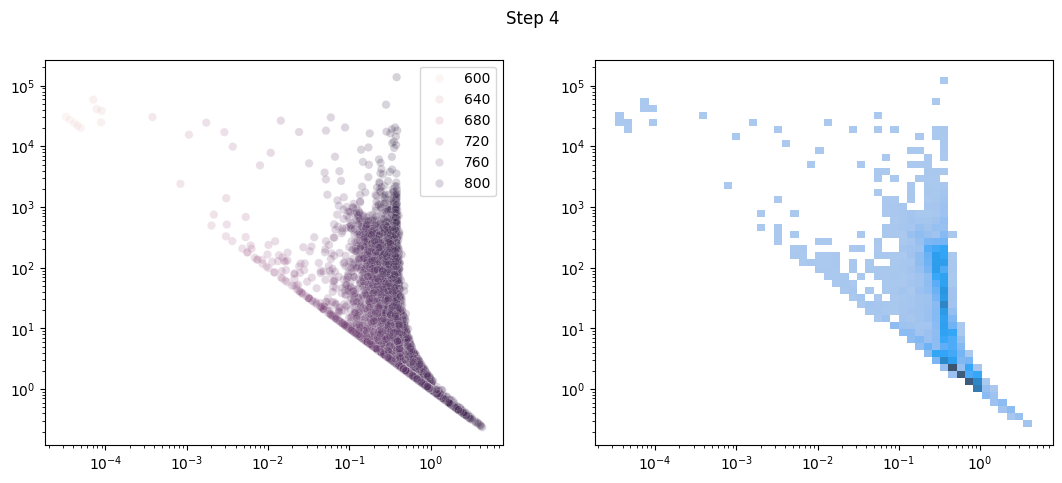

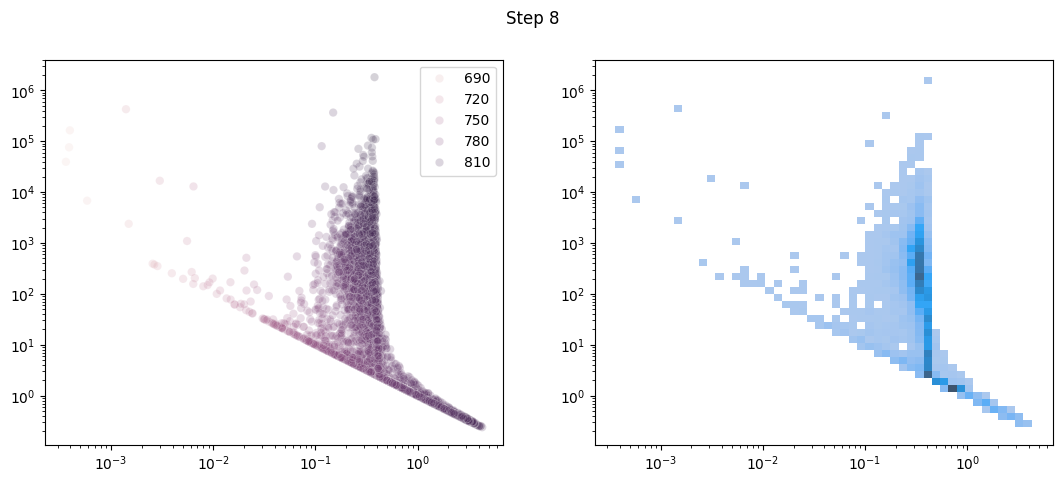

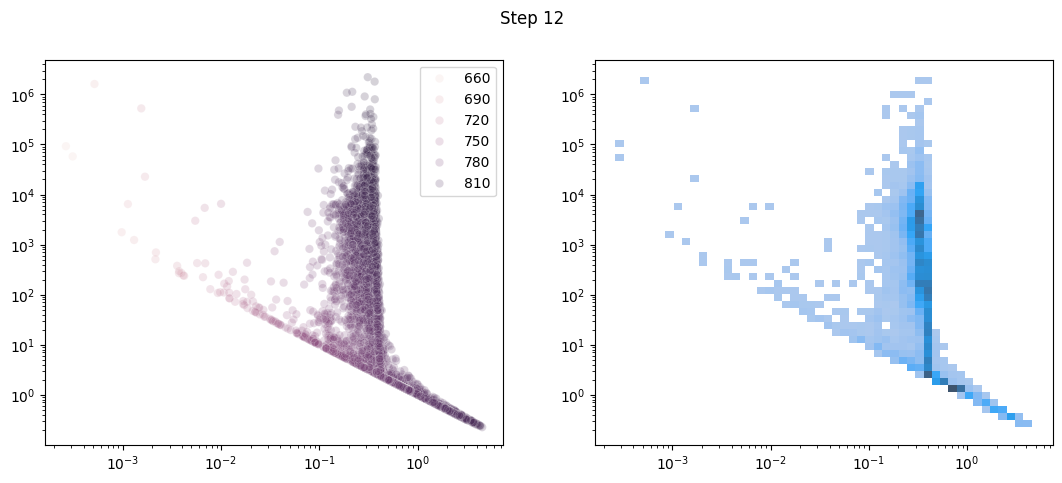

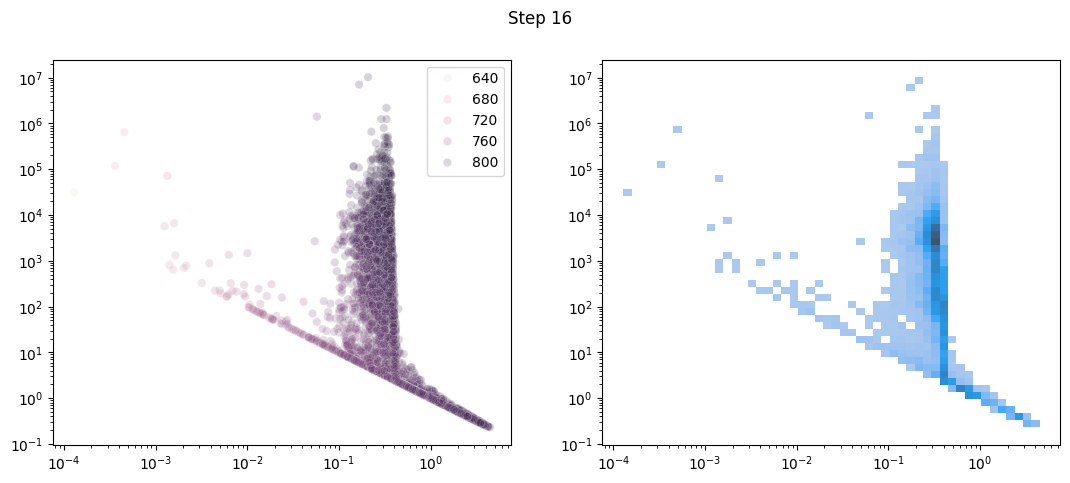

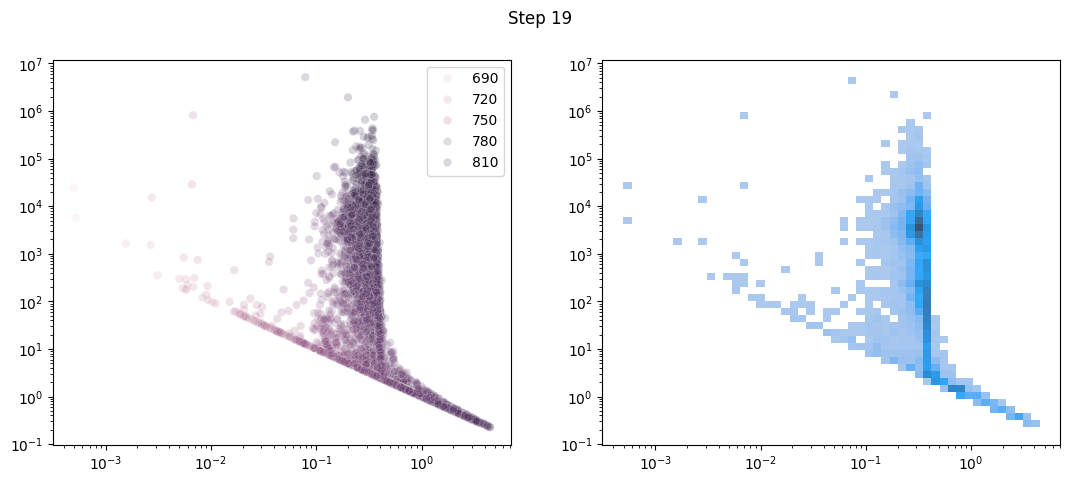

In [11]:
if run_mc:

    n_samples_per_parent = int(np.ceil(total_samples/choose_max))

    # [total_steps, n_outputs, n_samples, n_reactions]
    all_params_en = np.zeros((total_steps, *reverse_rates.shape))
    all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
    all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
    all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
    all_adaptability = np.zeros((total_steps, total_samples, len(species)))
    all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
    all_precision = np.zeros((total_steps, total_samples, len(species)))

    save_steps_ts = np.logspace(np.log10(t0 + 1), np.log10(t1), save_steps, base=10, endpoint=True) - 1.
    sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                                t0=t0, t1=t1, dt0=dt0,
                                forward_rates=forward_rates,
                                inputs=inputs,
                                outputs=outputs,
                                solver=get_diffrax_solver(sim_method),
                                # saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                                saveat=dfx.SaveAt(ts=save_steps_ts),
                                max_steps=16**5,
                                stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

    curr_en = energies

    for step in range(total_steps):

        print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

        curr_eq = jax.vmap(
            partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
        _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

        ys0, ts0, ys1, ts1 = simulate(
            y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
        next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                      use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max,
                                                                      total_samples=total_samples, diversity=diversity)
        print(f'Choosing {len(next_idxs)} next circuits')
        if len(next_idxs) < choose_max:
            print('Not enough circuits chosen, will randomly choose the rest')
            idxs_rnd = choose_next_rnd(
                choose_max - len(next_idxs), total_samples)
            next_idxs = jnp.concatenate([next_idxs, idxs_rnd])

        if np.mod(step, int(total_steps/5)) == 0:
            plt.figure(figsize=(13, 5))
            ax = plt.subplot(1, 2, 1)
            sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(
            ), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
            plt.xscale('log')
            plt.yscale('log')
            ax = plt.subplot(1, 2, 2)
            sns.histplot(x=sensitivity[:, idxs_output].flatten(
            ), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
            plt.suptitle(f'Step {step}')

        # Save results
        all_params_en[step] = curr_en
        all_params_eq[step] = curr_eq
        all_params_rt[step] = curr_rt
        all_is_parent[step][next_idxs] = True
        all_adaptability[step] = adaptability
        all_sensitivity[step] = sensitivity
        all_precision[step] = precision

        # Mutate energies
        next_en = mutate_expand(
            curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
        print(
            f'Mutated and expanding {len(next_idxs)} into {len(next_en)} next circuits')
        curr_en = next_en

    df = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(),
                            'Sensitivity': all_sensitivity[..., idxs_output].flatten(),
                            'Precision': all_precision[..., idxs_output].flatten(),
                            'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                            'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                            'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                            'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                            'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                            'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                            'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})
    if not os.path.exists(fn_save):
        df.sort_values(by='Adaptability', ascending=False).to_csv(fn_save, index=False)

    plt.figure(figsize=(13, 5))
    ax = plt.subplot(1, 2, 1)
    sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(
    ), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    ax = plt.subplot(1, 2, 2)
    sns.histplot(x=sensitivity[:, idxs_output].flatten(
    ), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
    plt.suptitle(f'Step {step}')

# Visualise

In [12]:
df_loaded = pd.read_csv(fn_save)
df_loaded.rename(columns={'Is parent circuit': 'Parent in next round'}, inplace=True)
df_loaded.columns

Index(['Adaptability', 'Sensitivity', 'Precision', 'Parent in next round',
       'Circuit idx', 'Species', 'Step', 'Params energy',
       'Params equilibrium constants', 'Params rates'],
      dtype='object')

/tmp/ipykernel_1061349/3203246314.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_1061349/3203246314.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


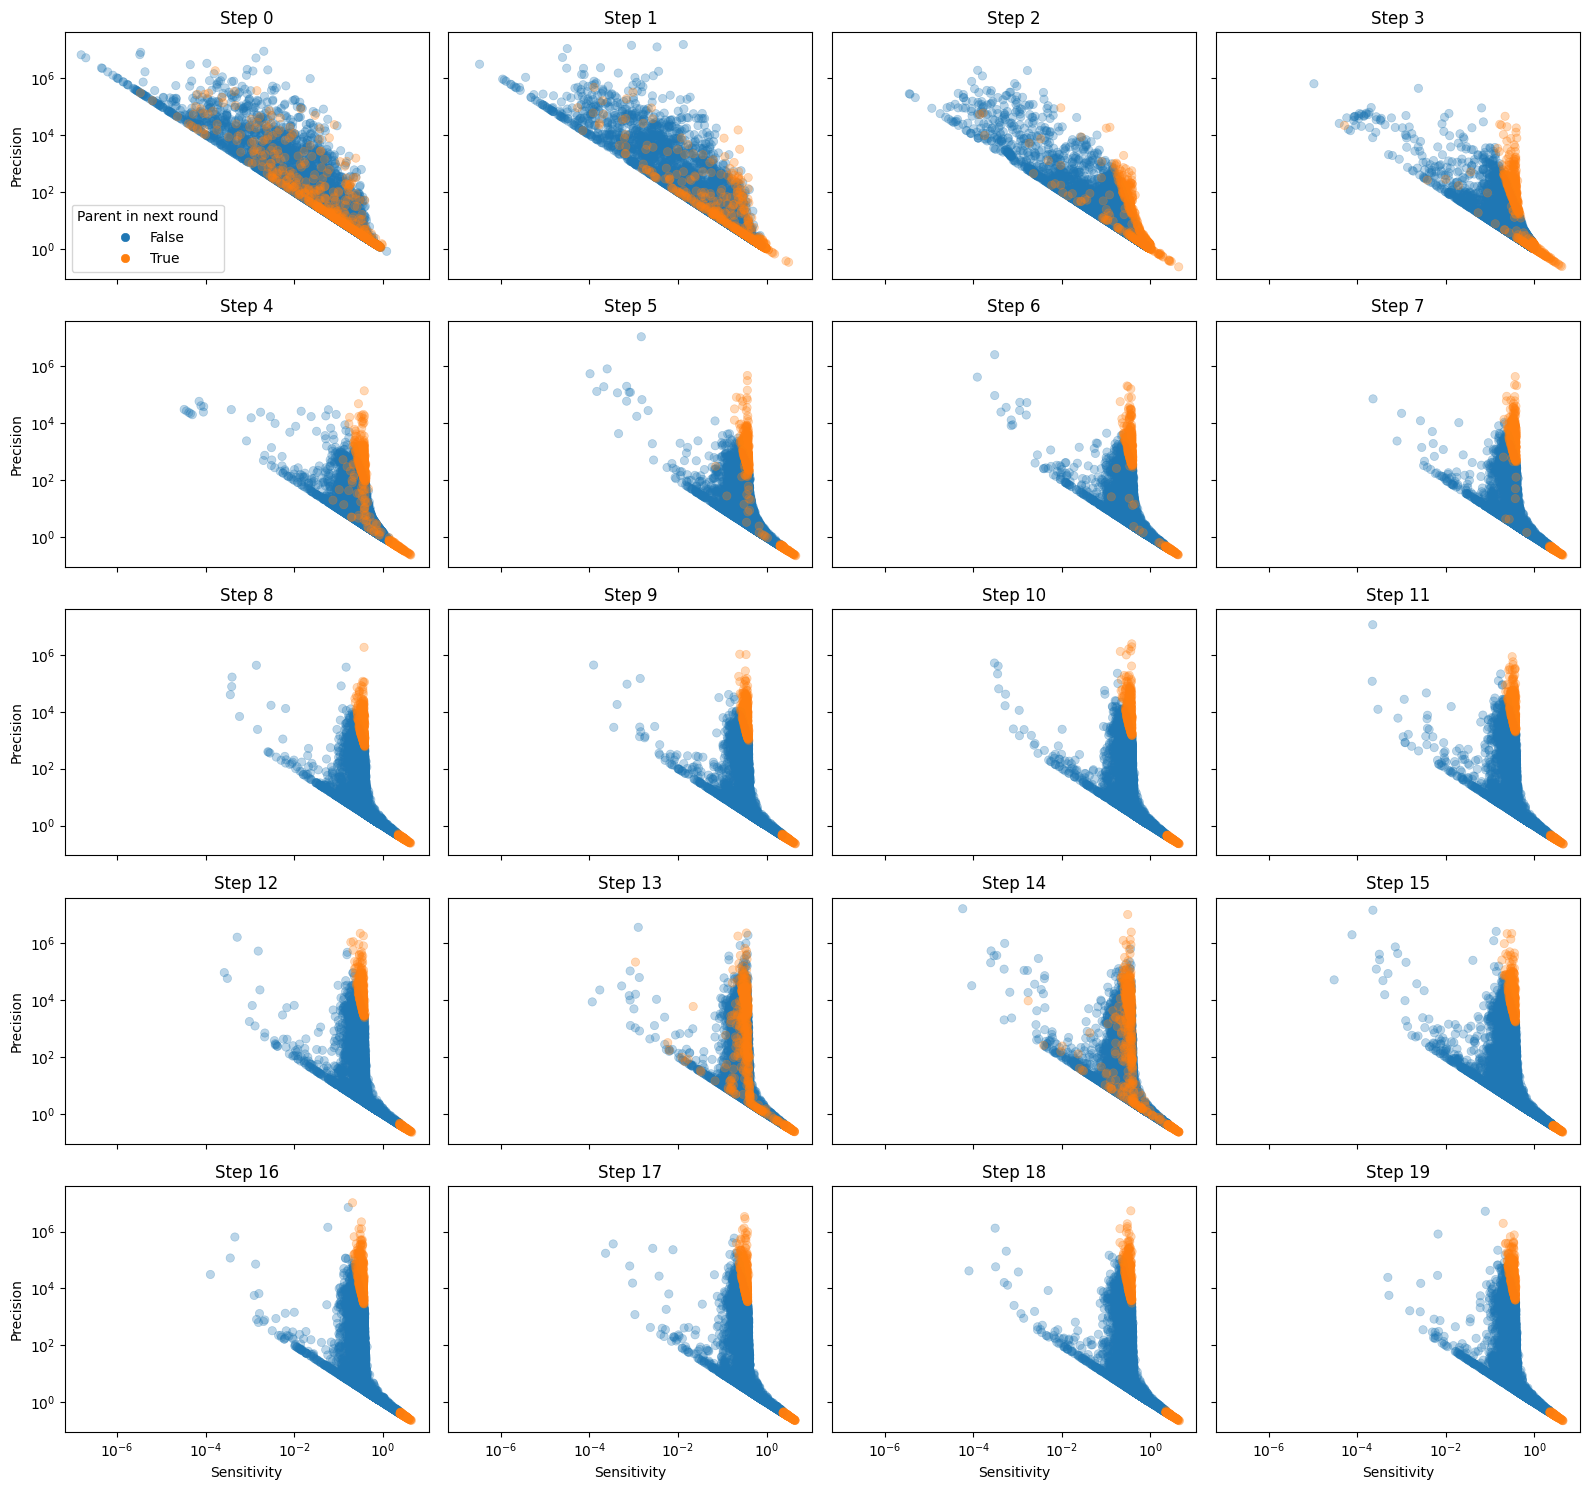

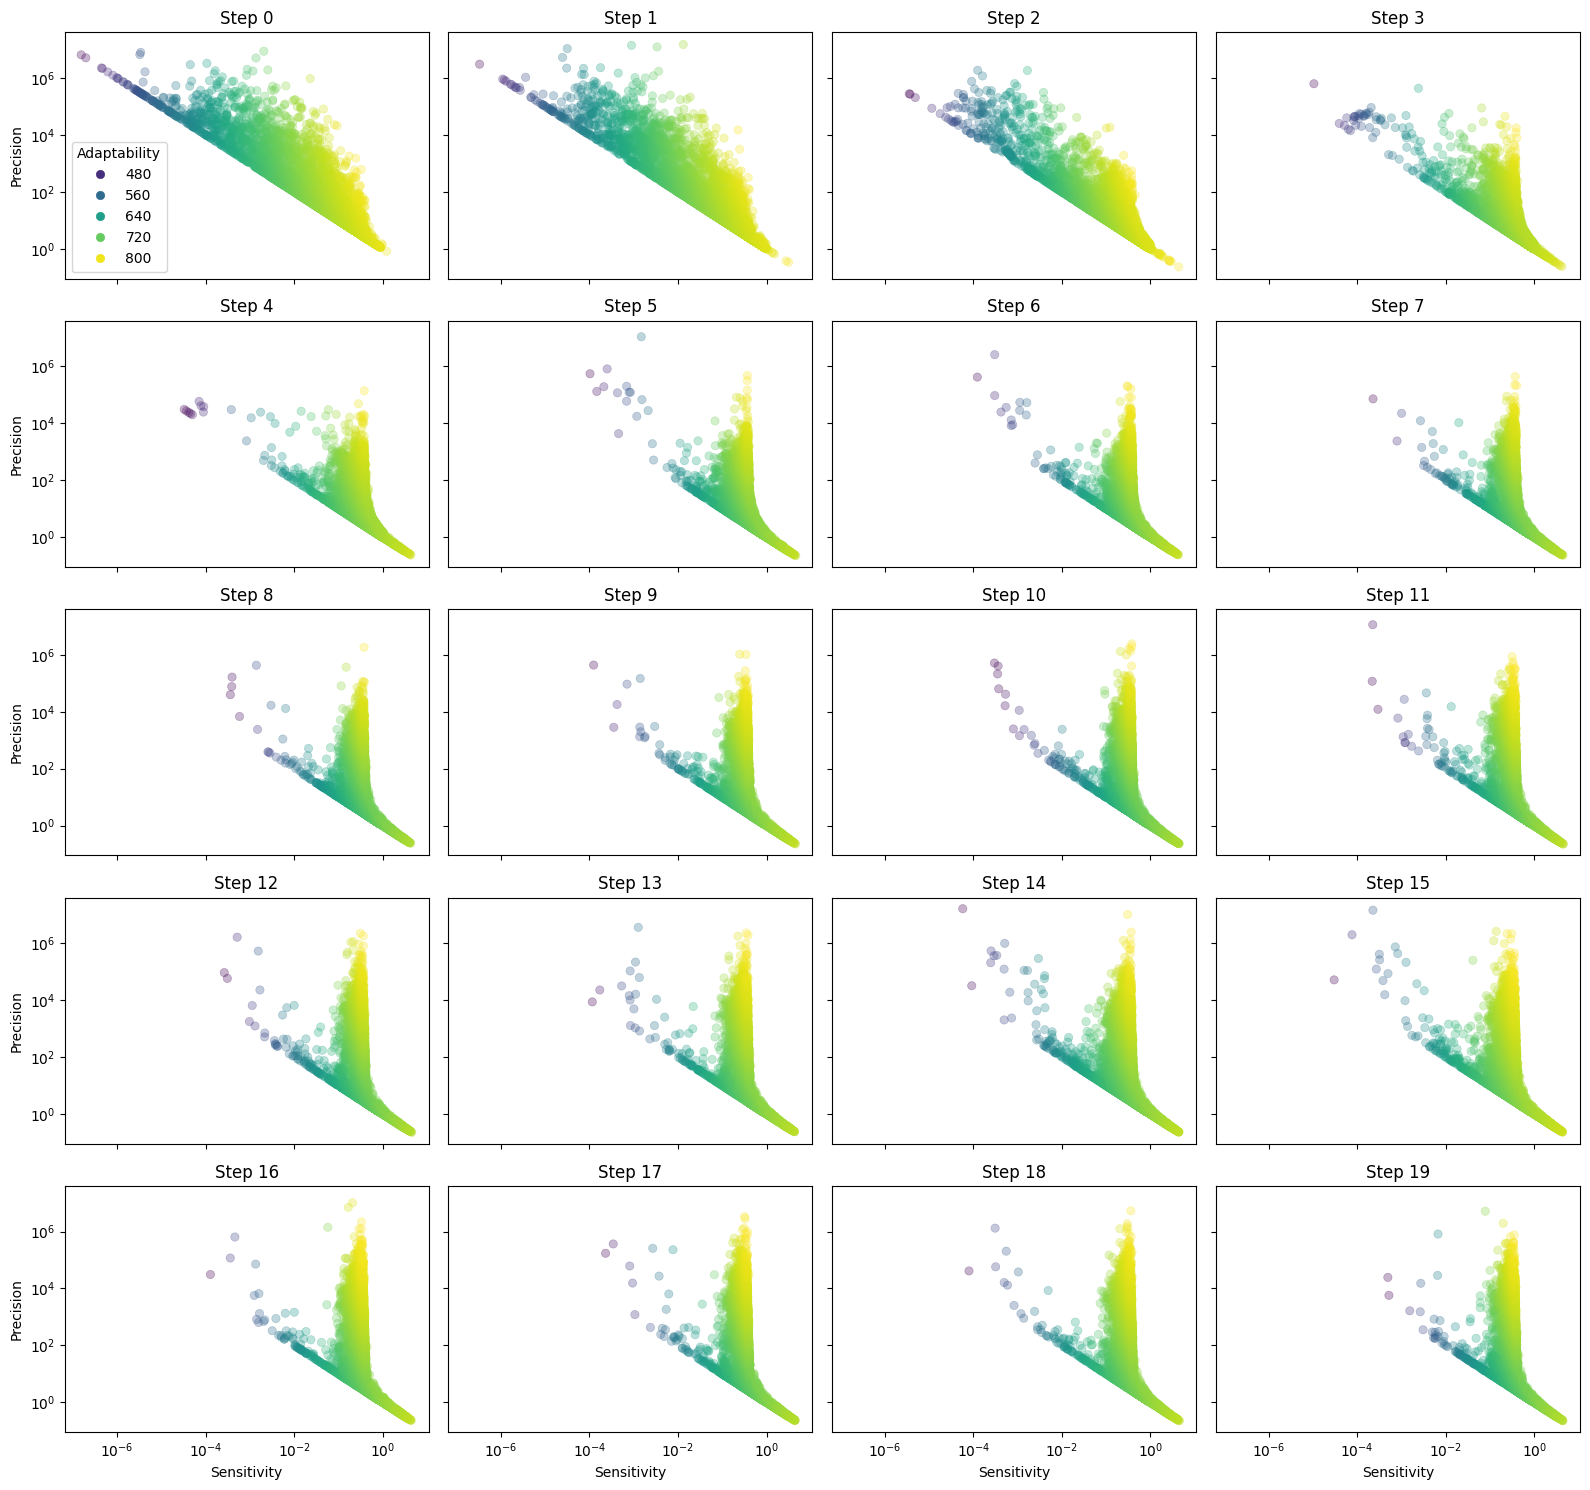

In [13]:
n_step = int(df_loaded['Step'].max()) + 1
nrows = int(np.ceil(np.sqrt(n_step)))
ncols = int(np.ceil(n_step / nrows))

hues = ['Parent in next round', 'Adaptability']
file_namings = ['scatter_sp_parent_new', 'scatter_sp_adaptability_new']
for hue, file_naming, palette in zip(hues, file_namings, [None, 'viridis']):
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), 
                            constrained_layout=True, sharex=True, sharey=True)
    for step in range(n_step):
        is_legend = True if step == 0 else False
        step_df = df_loaded[df_loaded['Step'] == step]
        g = sns.scatterplot(data=step_df.sort_values(by=hue), 
                        x='Sensitivity', y='Precision', 
                        hue=hue, ax=axs.flat[step],
                        alpha=0.3, edgecolor=None, palette=palette,
                        legend=is_legend)
        axs.flat[step].set_xscale('log')
        axs.flat[step].set_yscale('log')
        axs.flat[step].set_title(f'Step {step}')

        if is_legend:
            for line in g.legend().get_lines():
                line.set_alpha(1)
            sns.move_legend(g, "lower left", title=hue)

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'{file_naming}.png'), dpi=300)